In [288]:
#@title Drug Design

In [333]:
# from google.colab import drive
# drive.mount("/content/drive")

In [334]:
# Import Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
import keras
from keras import layers
from keras.models import Model 
from keras import metrics
from keras import backend as K 
import tensorflow as tf 
from tensorflow.keras.optimizers import Adam 
import warnings 
import matplotlib.pyplot as plt
from tqdm import tqdm
import random

In [335]:
# Set environment variables and clear sessions
K.clear_session()
np.random.seed(237)
warnings.filterwarnings("ignore")
tf.compat.v1.disable_eager_execution()
%matplotlib inline

In [336]:
## Import Dataset from drive for Smile representation of drug molecules:
data = pd.read_csv('/content/drive/MyDrive/Dataset/MoleculeSythesis/dataset/AA.csv')
data.head()

,zinc_id,smiles
0,ZINC000000008151,C[C@H]1[C@@H](O)[C@H](CO)O[C@@H](O)[C@@H]1N
1,ZINC000000008153,CC[C@@H]1[C@@H](N)[C@@H](O)O[C@@H](CO)[C@@H]1O
2,ZINC000000008155,CC1(C)[C@@H](N)[C@@H](O)O[C@@H](CO)[C@@H]1O
3,ZINC000000018276,CS[C@@H]1CN[C@@H](CO)[C@H](O)[C@H]1O
4,ZINC000000018279,CS[C@@H]1[C@@H](O)CN[C@@H](CO)[C@@H]1O


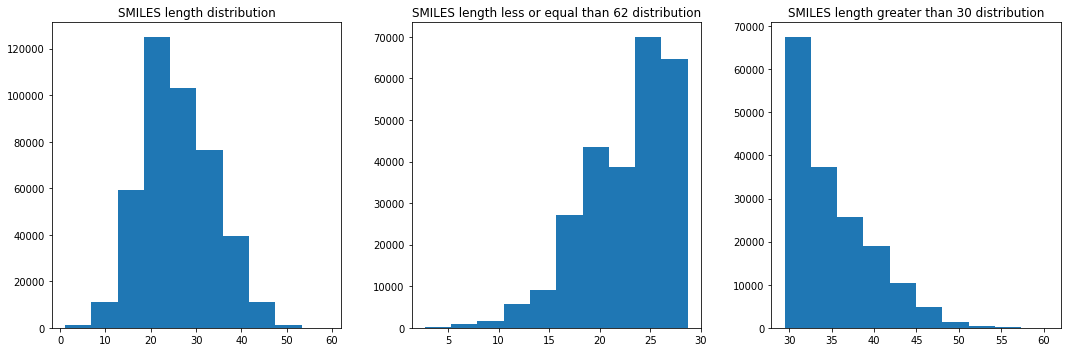

In [337]:
#### Plot distribution of smile molecules vs the molecule length
fig, axes = plt.subplots(nrows = 1, ncols = 3, figsize = (15, 5))
axes[0].set_title("SMILES length distribution")
axes[0].hist(data['smiles'].str.len(), align = 'left')
axes[1].set_title("SMILES length less or equal than 62 distribution")
axes[1].hist(data[data['smiles'].str.len() <= 30]['smiles'].str.len(), align = 'left')
axes[2].set_title("SMILES length greater than 30 distribution")
axes[2].hist(data[data['smiles'].str.len() > 30]['smiles'].str.len(), align = 'left')
fig.tight_layout()
plt.show()

In [351]:
# Super set of characters used for smile generations
SMILES_CHARS = [' ',
                  '#', '%', '(', ')', '+', '-', '.', '/',
                  '0', '1', '2', '3', '4', '5', '6', '7', '8', '9',
                  '=', '@',
                  'A', 'B', 'C', 'F', 'H', 'I', 'K', 'L', 'M', 'N', 'O', 'P',
                  'R', 'S', 'T', 'V', 'X', 'Z',
                  '[', '\\', ']',
                  'a', 'b', 'c', 'e', 'g', 'i', 'l', 'n', 'o', 'p', 'r', 's',
                  't', 'u'
]

In [353]:
#### Create dictionaries from character set for encoding and decoding smiles
encoder_dict = dict( (c,i) for i,c in enumerate( SMILES_CHARS ) )
decoder_dict = dict( (i,c) for i,c in enumerate( SMILES_CHARS ) )
print(encoder_dict)
print(decoder_dict)

{' ': 0, '#': 1, '%': 2, '(': 3, ')': 4, '+': 5, '-': 6, '.': 7, '/': 8, '0': 9, '1': 10, '2': 11, '3': 12, '4': 13, '5': 14, '6': 15, '7': 16, '8': 17, '9': 18, '=': 19, '@': 20, 'A': 21, 'B': 22, 'C': 23, 'F': 24, 'H': 25, 'I': 26, 'K': 27, 'L': 28, 'M': 29, 'N': 30, 'O': 31, 'P': 32, 'R': 33, 'S': 34, 'T': 35, 'V': 36, 'X': 37, 'Z': 38, '[': 39, '\\': 40, ']': 41, 'a': 42, 'b': 43, 'c': 44, 'e': 45, 'g': 46, 'i': 47, 'l': 48, 'n': 49, 'o': 50, 'p': 51, 'r': 52, 's': 53, 't': 54, 'u': 55}
{0: ' ', 1: '#', 2: '%', 3: '(', 4: ')', 5: '+', 6: '-', 7: '.', 8: '/', 9: '0', 10: '1', 11: '2', 12: '3', 13: '4', 14: '5', 15: '6', 16: '7', 17: '8', 18: '9', 19: '=', 20: '@', 21: 'A', 22: 'B', 23: 'C', 24: 'F', 25: 'H', 26: 'I', 27: 'K', 28: 'L', 29: 'M', 30: 'N', 31: 'O', 32: 'P', 33: 'R', 34: 'S', 35: 'T', 36: 'V', 37: 'X', 38: 'Z', 39: '[', 40: '\\', 41: ']', 42: 'a', 43: 'b', 44: 'c', 45: 'e', 46: 'g', 47: 'i', 48: 'l', 49: 'n', 50: 'o', 51: 'p', 52: 'r', 53: 's', 54: 't', 55: 'u'}


In [354]:
smiles_data = data['smiles'][:250000]
smiles_data = np.array(smiles_data).reshape(-1)
print('Number of mols: '+str(len(smiles_data)))
idx = [i for i, x in enumerate(smiles_data) if len(x)<=120]
print('Number of valid mols: '+str(len(idx)))
smiles_data = smiles_data[idx]
print('Getting a unique character set...')

Number of mols: 250000
Number of valid mols: 250000
Getting a unique character set...


In [355]:
char_set = set()
for i in tqdm(range(len(smiles_data))):
    smiles_data[i] = smiles_data[i].ljust(62)
    char_set = char_set.union(set(smiles_data[i]))
char_set_list = sorted(list(char_set))
print('Number of characters: '+str(len(char_set_list)))

100%|██████████| 250000/250000 [00:00<00:00, 394229.22it/s]

Number of characters: 37


In [356]:
def one_hot_encoder( smiles ):
    X = np.zeros( ( 62, len( SMILES_CHARS ) ) )
    for i, c in enumerate( smiles ):
        X[i, encoder_dict[c]] = 1
    return X

def one_hot_decoder( X ):
    smi = ''
    X = X.argmax( axis=-1 )
    for i in X:
        smi += decoder_dict[i]
    return smi

In [357]:
x = []
for i in data['smiles'][:500]:
    x.append(one_hot_encoder(i))
arr = np.array(x)

In [344]:
arr = arr.reshape(-1,62,56,1)
arr.shape

(500, 62, 56, 1)

In [345]:
img_shape = (62, 56,1)
batch_size = 16
latent_dim = 2
input_img = keras.Input(shape=img_shape)
x = layers.Conv1D(32, 7,
                  padding='same',
                  activation='relu',
                  )(input_img)
x = layers.Conv2D(128, 3,
                  padding='same',
                  activation='relu',
                  strides=(2, 2))(x)
x = layers.Conv2D(128, 3,
                  padding='same',
                  activation='relu')(x)
x = layers.Conv2D(128, 3,
                  padding='same',
                  activation='relu')(x)
shape_before_flattening = K.int_shape(x)
x = layers.Flatten()(x)
x = layers.Dense(32, activation='relu')(x)
z_mu = layers.Dense(latent_dim)(x)
z_log_sigma = layers.Dense(latent_dim)(x)

In [346]:
def sampling(args):
  z_mu, z_log_sigma = args
  epsilon = K.random_normal(shape=(K.shape(z_mu)[0], latent_dim),
  mean=0., stddev=1.)
  return z_mu + K.exp(z_log_sigma) * epsilon
z = layers.Lambda(sampling)([z_mu, z_log_sigma])

In [347]:
decoder_input = layers.Input(K.int_shape(z)[1:])
x = layers.Dense(np.prod(shape_before_flattening[1:]),
                 activation='relu')(decoder_input)
x = layers.Reshape(shape_before_flattening[1:])(x)
x = layers.Conv2DTranspose(32, 3,
                           padding='same',
                           activation='relu',
                           strides=(2, 2))(x)
x = layers.Conv2D(1, 3,
                  padding='same',
                  activation='sigmoid')(x)
decoder = Model(decoder_input, x)
z_decoded = decoder(z)

In [348]:
class CustomVariationalLayer(keras.layers.Layer):
    def vae_loss(self, x, z_decoded):
        x = K.flatten(x)
        z_decoded = K.flatten(z_decoded)
        xent_loss = keras.metrics.binary_crossentropy(x, z_decoded) #Recin loss
        kl_loss = -5e-4 * K.mean(1 + z_log_sigma - K.square(z_mu) - K.exp(z_log_sigma), axis=-1) #KL loss
        return K.mean(xent_loss + kl_loss)

    def call(self, inputs):
        x = inputs[0]
        z_decoded = inputs[1]
        loss = self.vae_loss(x, z_decoded)
        self.add_loss(loss, inputs=inputs)
        return x

y = CustomVariationalLayer()([input_img, z_decoded])

In [349]:
# VAE model statement
vae = Model(input_img, y)
vae.compile(optimizer='rmsprop', loss=None)
vae.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 62, 56, 1)]  0                                            
__________________________________________________________________________________________________
conv1d (Conv1D)                 (None, 62, 56, 32)   256         input_1[0][0]                    
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 31, 28, 128)  36992       conv1d[0][0]                     
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 31, 28, 128)  147584      conv2d[0][0]                     
____________________________________________________________________________________________

In [350]:
vae.fit(x=arr, y=None,
        shuffle=False,
        epochs=120,
        batch_size=batch_size,
)

Train on 500 samples
Epoch 1/120
500/500 [==============================] - 1s 2ms/sample - loss: 651432.5542
Epoch 2/120
500/500 [==============================] - 0s 637us/sample - loss: 0.0484
Epoch 3/120
500/500 [==============================] - 0s 633us/sample - loss: 0.0389
Epoch 4/120
500/500 [==============================] - 0s 625us/sample - loss: 0.0367
Epoch 5/120
500/500 [==============================] - 0s 619us/sample - loss: 0.0354
Epoch 6/120
500/500 [==============================] - 0s 616us/sample - loss: 0.0354
Epoch 7/120
500/500 [==============================] - 0s 628us/sample - loss: 0.0353
Epoch 8/120
500/500 [==============================] - 0s 626us/sample - loss: 0.0343
Epoch 9/120
500/500 [==============================] - 0s 624us/sample - loss: 0.0344
Epoch 10/120
500/500 [==============================] - 0s 608us/sample - loss: 0.0338
Epoch 11/120
500/500 [==============================] - 0s 617us/sample - loss: 0.0343
Epoch 12/120
500/500 [======

In [264]:
result = []
for i in random.sample(range(1, 10000000), 100):
  for j in random.sample(range(1, 10000000), 100):
    sample_vector = np.array([[i,j]])
    res = decoder.predict(sample_vector)
    res = res[0].reshape(62,56)
    result.append(one_hot_decoder(res).replace(' ',''))
set(result)

{'@H]11[@@H(())[@@H]())[@@H(O))C@@H]1)P',
 '@H]11[@@H(())[@@H]())[@@H]O))C@@H]1)P',
 '@H]11[@@H(())[@@H]))[@@H]O))C@@H]1)P',
 '@H]11[@@H(())[@@H]))[@@H]O))C@@H]1OP',
 'C11[@@H(())C@@H2(O))@@H]())OC@@H]))[P@]',
 'C11[@@H(())C@@H2(O))@@H](O)OC@@H]))[P@]',
 'C11[@@H(())C@@H2(O))@@H](O)OC@@H]))[P]',
 'C@H]11[@@H(())C@@H]())[@@@](O)OC@@H])P',
 'C@H]11[@@H(())C@@H]())[@@@](O)OC@@H]1)P',
 'C@H]11[@@H(())[@@H]())[@@@](O))C@@H]1)P',
 'C@H]11[@@H(())[@@H]())[@@@](O)OC@@H]1)P',
 'C@H]11[@@H(())[@@H]())[@@H(O))C@@H]1)P',
 'C@H]11[@@H(())[@@H]())[@@](O))C@@H]1)P',
 'C@]11[@@H(())C@@H]())[@@@](O)OC@@H])P',
 'C@]11[@@H(())C@@H]())[@@H](O)OC@@H])P',
 'C@]11[@@H(())C@@H]())[@@H](O)OC@@H])[P',
 'CCN)[@@H())C@@H](O))@@H())OC@HH)[P@O',
 'CCN11[@@H())C@@H2(O))@@H(())OC@@H])[P@O',
 'CCN11[@@H())C@@H](O))@@H(())OC@@H])[P@O',
 'CCN1[@@H())C@@H](O))@@H(())OC@@H)[P@O',
 'CCN1[@@H())C@@H](O))@@H())OC@HH)[P@O',
 'CCN1c[@@H())C@@H](O))@@H())OC@HH)[P@O',
 'CN11[@@H(())C@@H2(O))@@H(())OC@@H]))[P@O',
 'CN11[@@H(())C@